# After initial struggles to work with irregular time series data in R, tried it in Python
# from https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

In [2]:
# load libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# !pip install pmdarima           Don't need to do this again!
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
# load the dataset
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('indiv_order_dates_for_Python.csv', index_col='OrderDate', parse_dates=['OrderDate'],
                  date_parser=dateparse).fillna(0)
data

,Quantity,Combining_Duplicates,Unnamed: 3
OrderDate,,,
2006-07-18,1,18.99,0
2007-05-21,1,15.63,0
2009-06-22,2,13.18,0
2009-07-22,1,43.45,0
2009-11-01,1,10.49,0
...,...,...,...
2021-06-21,1,418.54,0
2021-06-22,1,48.46,0
2021-06-24,1,21.09,0


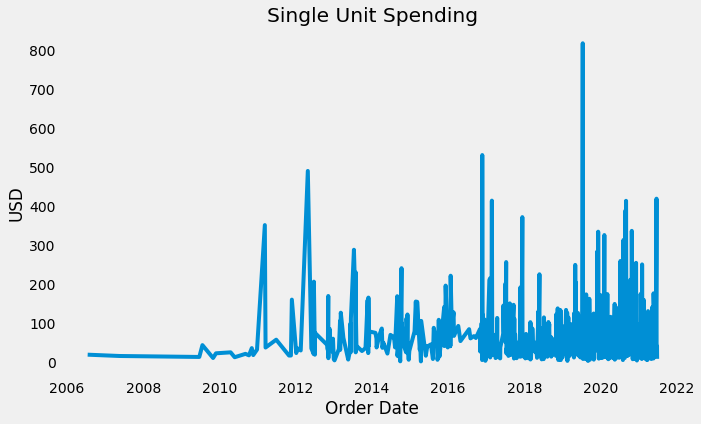

In [3]:
# visualize the amount spent, per day, for both spouses
#plot close price
plt.figure(figsize=(10,6))
plt.grid(False)
plt.xlabel('Order Date')
plt.ylabel('USD')
plt.plot(data['Combining_Duplicates'])
plt.title('Single Unit Spending')
plt.show()

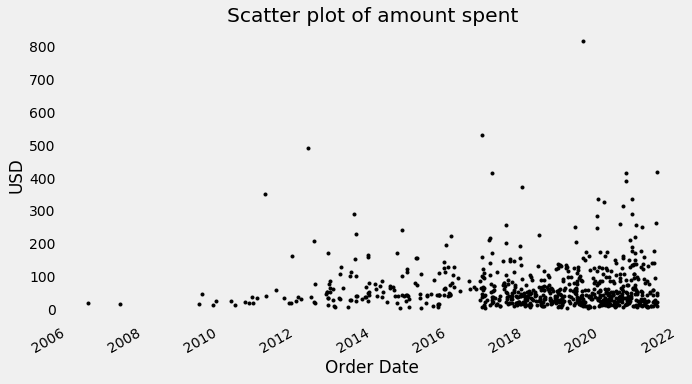

In [4]:
# plot the scatterplot
df_dollars = data['Combining_Duplicates']
df_dollars.plot(style='k.')
plt.grid(False)
plt.xlabel('Order Date')
plt.ylabel('USD')
plt.title('Scatter plot of amount spent')
plt.show()

from https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

"First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

So let's check for stationarity:"

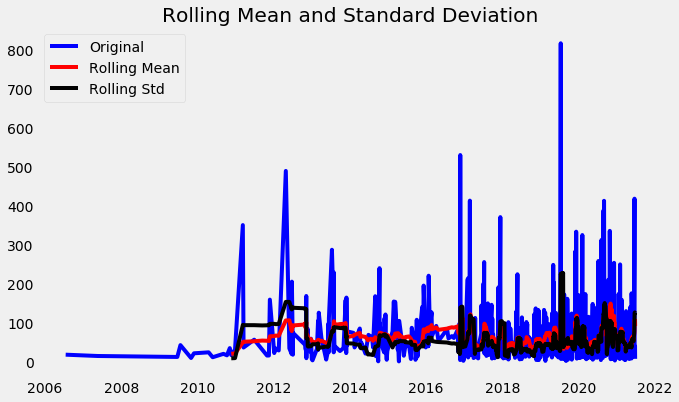

Results of dickey fuller test
Test Statistics                -24.537895
p-value                          0.000000
No. of lags used                 0.000000
Number of observations used    712.000000
critical value (1%)             -3.439568
critical value (5%)             -2.865608
critical value (10%)            -2.568936
dtype: float64


In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.grid(False)
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():            # explain the values with a for loop
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_dollars)

The p-value is < 0.05, so we can reject the Null hypothesis.  The data has a unit root.  Also, the test statistic is NOT greater than the critical values.  The dataset is stationary.

I believe this means that I do not need to do a seasonality decomposition or separate trend from the series in order to make it stationary.

"...find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series."

No handles with labels found to put in legend.


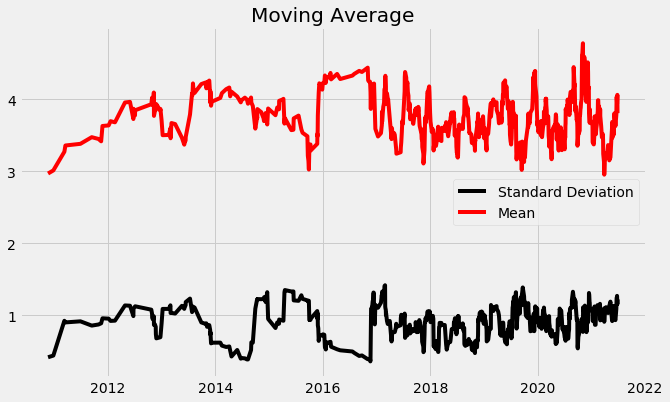

In [6]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_dollars)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

I am uncertain what the y axis represents.  It is not USD.

Now we are going to create an ARIMA model and will train it with the dollars spent on the train data. So let us split the data into training and test set and visualize it.

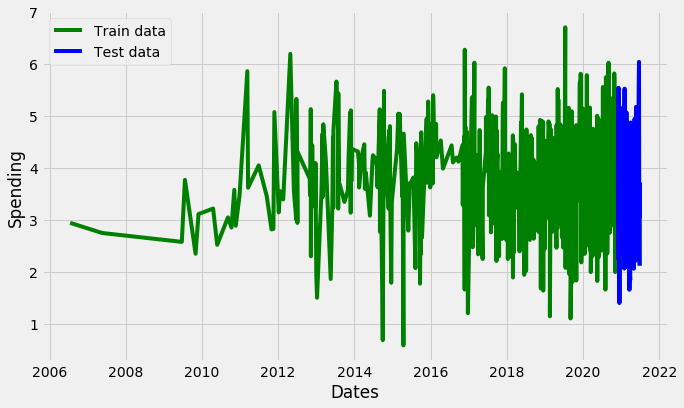

In [7]:
# split data into train and training set
# I'm not sure about the log part of this
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Spending')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Explanation of steps taken from https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html

"Its time to choose parameters p,q,d for ARIMA model. Last time we chose the value of p,d, and q by observing the plots of ACF and PACF but now we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.
The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D."

In [8]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3544.968, Time=15.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2122.520, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3022.580, Time=3.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1949.631, Time=1.33 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1733.837, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1732.066, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1733.850, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2725.800, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1735.672, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1723.341, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1724.254, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1724.157, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1726.787, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   :

I don't know why it says 'SARIMAX Results' in the output.  The output of the code that I followed to do this says 'ARIMA Model Results.'

### Insert 'out of the blue' section of code here

In [23]:
# out of the blue, different program's code; 
# https://colab.research.google.com/github/goodboychan/chans_jupyter/blob/master/_notebooks/2020-06-15-02-Fitting-the-Future.ipynb#scrollTo=Sahqxcq6rwIC
# Generate predictions
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data.loc['2006-07-18':'2021-06-27'], order=(3, 1, 3), seasonal_order=(1, 0, 1, 7),
                enforce_invertibility=False,
                enforce_stationarity=False,
                simple_differencing=False, 
                measurement_error=False,
                k_trend=0)
results = model.fit()

# This did not get me what I expected, but I am going to keep going.

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [15]:
results.summary()         # Aha.  Good thing I kept going.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                Combining_Duplicates   No. Observations:                  638
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 7)   Log Likelihood                -841.995
Date:                             Sat, 24 Jul 2021   AIC                           1701.990
Time:                                     18:22:58   BIC                           1741.944
Sample:                                          0   HQIC                          1717.514
                                             - 638                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5607      0.270      2.075      0.038       0.031       1.090
ar.L2         -0.6535      0.222     -2.940      0.003      -1.089      -0.218
ar.L3         -0.0406      0.044     -0.932      0.351      -0.126       0.045
ma.L1         -1.5755      0.269     -5.867      0.000      -2.102      -1.049
ma.L2          1.2322      0.406      3.036      0.002       0.437       2.028
ma.L3         -0.6827      0.220     -3.099      0.002      -1.114      -0.251
ar.S.L7       -0.1078      0.386     -0.279      0.780      -0.865       0.649
ma.S.L7        0.1490      0.388      0.384      0.701      -0.611       0.909
sigma2         0.8205      0.047     17.406      0.000       0.728       0.913
===================================================================================
Ljung-Box (Q):                       28.17   Jarque-Bera (JB):                 5.05
Prob(Q):                              0.92   Prob(JB):                         0.08
Heteroskedasticity (H):               1.06   Skew:                            -0.18
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate  predictions
print(mean_forecast.values)

# This generates lines and lines of errors.

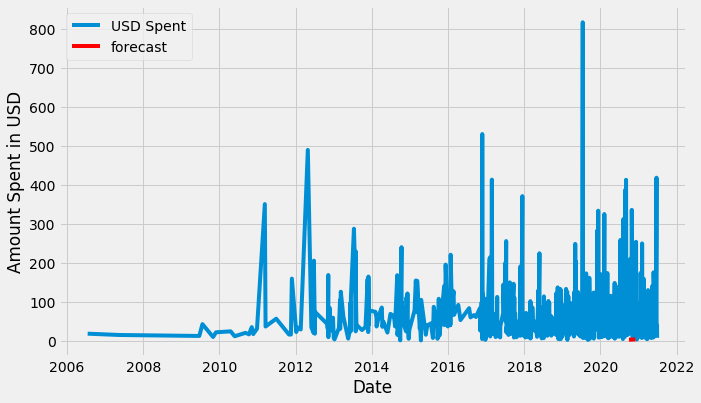

In [21]:
# Plotting one-step-ahead predictions
# Plot the spending data
plt.plot(data.index, data['Combining_Duplicates'], label='USD Spent');

# Plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast');

# shade the area between your confidence limits
#plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink');  # This caused an error.

# Set labels, legends
plt.xlabel('Date');
plt.ylabel('Amount Spent in USD');
plt.legend();

This certainly is not a helpful 'forecast.'

### End 'out of the blue' section of code

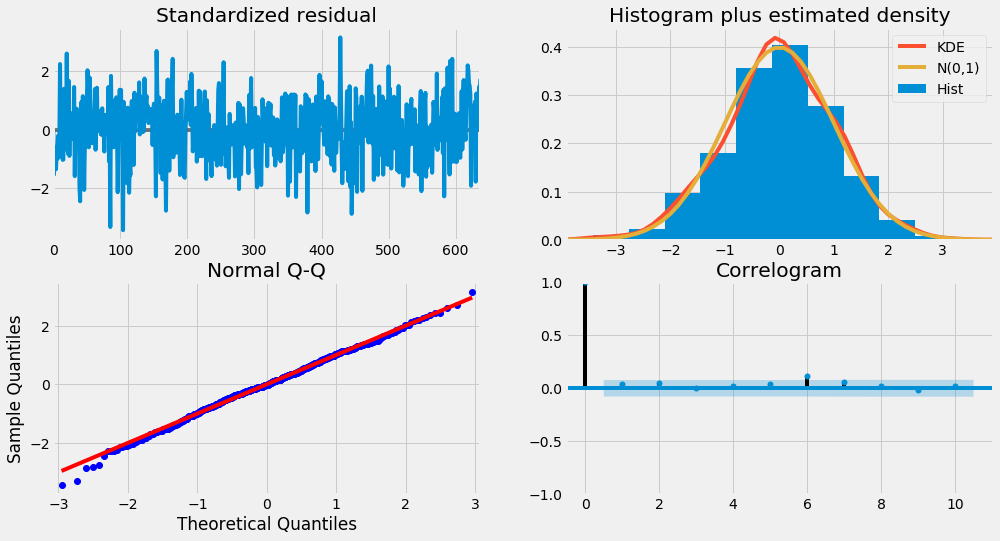

In [9]:
# Review the residual plots from auto ARIMA.
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

What do these mean?  (explanations from https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html)

"Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Top Right: The density plot suggest normal distribution with mean zero.

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit. Let’s start forecasting the amount spent.

Next, create an ARIMA model with provided optimal parameters p, d and q."

In [10]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Branch\Anaconda3\anaconda_mess\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Combining_Duplicates   No. Observations:                  637
Model:                     ARIMA(3, 1, 2)   Log Likelihood                -858.843
Method:                           css-mle   S.D. of innovations              0.928
Date:                    Sat, 24 Jul 2021   AIC                           1731.686
Time:                            17:38:54   BIC                           1762.884
Sample:                                 1   HQIC                          1743.798
                                                                                  
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.0002      0.000      0.484      0.628      -0.001       0.001
ar.L1.D.Combining_Duplicates     0.9661      

In [11]:
# Start to forecast spending on the test dataset keeping 95% confidence interval.
# Forecast

fc, se, conf = fitted.forecast(713, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Spending')
plt.plot(fc_series, color = 'orange',label='Predicted Spending')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Single Family Amazon Spending Prediction')
plt.xlabel('Time')
plt.ylabel('Spending in USD')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: Length of passed values is 713, index implies 72.

In [1]:
# Start to forecast spending on the test dataset keeping 95% confidence interval.
# Forecast

#fc, se, conf = fitted.forecast(713, alpha=0.05)  # 95% confidence
fc, se, conf = fitted.forecast(len(train_data), alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Spending')
plt.plot(fc_series, color = 'orange',label='Predicted Spending')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Single Family Amazon Spending Prediction')
plt.xlabel('Time')
plt.ylabel('Spending in USD')
plt.legend(loc='upper left', fontsize=8)
plt.show()

NameError: name 'fitted' is not defined